# BRSM Project: The Relation between Preference for Predictability and Autistic Traits 

- Paper: [link](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0275308)
- Team:
    - Adhiraj
    - Sanyam
    - Abhijeet

In [1]:
## Setup
import os
import numpy as np
import pandas as pd

from scipy import stats
import pingouin as pg
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor']='white' # [white, wheat]

# Options for rendering the plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Perceptual Fluency Task

In [2]:
## Participant List
n_total = 164
arr_removed = [97, 105, 117]  # inconsistent AQ/SRS scores

n_rem = n_total - len(arr_removed)

### Perceptual Fluency Task Variables

--------------------------
+ ppnr = participant number
+ trialnr = trial number
+ preference = ratings on likert scale between 1 (least beautiful) to 7 (most beautiful)
+ rt = reaction time in seconds
+ target_nr = number of target image
+ prime_nr = number of prime image
+ matching = congruency, 0 (incongruent) or 1 (congruent)
+ t_prime = presentation time of prime in seconds

### 2.1) Load Data

#### 2.1.1) Perception Fluency Data

In [3]:
import os

perception_data = f'./data/PerceptualFluencyTask'

perception_results = f'./results/PerceptualFluencyTask'
os.makedirs(perception_results, exist_ok=True)

arr_files = [file for file in os.listdir(perception_data) if file.endswith(".rtd") and (int(''.join([x for x in file if x.isdigit()])) not in arr_removed)]
arr_files = sorted(arr_files, key = lambda file : int(''.join([x for x in file if x.isdigit()])))

arr_files[:11]

['fluency_ppn01.rtd',
 'fluency_ppn02.rtd',
 'fluency_ppn03.rtd',
 'fluency_ppn04.rtd',
 'fluency_ppn05.rtd',
 'fluency_ppn06.rtd',
 'fluency_ppn07.rtd',
 'fluency_ppn08.rtd',
 'fluency_ppn09.rtd',
 'fluency_ppn10.rtd',
 'fluency_ppn11.rtd']

In [4]:
import pandas as pd
import os

perception_df = pd.DataFrame()

for file in arr_files:
    temp_df = pd.read_csv(os.path.join(perception_data, file), sep='\t')
    perception_df = pd.concat([perception_df, temp_df], axis=0, ignore_index=True)

print(f'n_samples: {len(perception_df)}')
perception_df.head()

n_samples: 16100


,ppnr,trialnr,preference,rt,target_nr,prime_nr,matching,t_prime
0,1,1,4,3.818357,77,115,0,0.033347
1,1,2,5,1.883501,18,18,1,0.033327
2,1,3,4,2.603399,56,56,1,0.033292
3,1,4,5,1.485485,3,117,0,0.032228
4,1,5,5,1.861445,62,105,0,0.033355


#### 2.1.2) Questionaire Data

In [5]:
asd_data = f'./data/QuestionnaireData.csv'

In [6]:
# asd_df = pd.read_csv(asd_data, sep=',', index_col='subj')
asd_df = pd.read_csv(asd_data, sep=',')

# asd_df = asd_df.drop(arr_removed, inplace=False)
asd_df = asd_df[~asd_df['subj'].isin(arr_removed)]

print(f'n_samples: {len(asd_df)}')

display(asd_df.head())

n_samples: 161


,subj,age,gender,handedness,AQ_total,AQ_social,AQ_switch,AQ_detail,AQ_comm,AQ_imag,AQ_binary,SRS_total,SRS_consc,SRS_comm,SRS_motiv,SRS_rigid,PCA_factor
0,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,34.0,110.0,24.0,37.0,26.0,23.0,3.114122
1,2,18,F,R,83.0,17.0,17.0,19.0,18.0,12.0,5.0,32.0,12.0,8.0,7.0,5.0,-1.050444
2,3,18,F,R,99.0,16.0,25.0,19.0,20.0,19.0,19.0,60.0,18.0,15.0,13.0,14.0,0.249674
3,4,18,M,R,104.0,16.0,24.0,21.0,22.0,21.0,12.0,35.0,11.0,14.0,7.0,3.0,-0.185610
4,5,31,F,R,85.5,16.0,19.0,19.0,15.5,16.0,10.0,23.0,9.0,4.0,4.0,6.0,-1.180812


#### 2.1.3) Cleaning Data
- Removing samples with missing data, i.e., $\text{NaNs}$
- Removing outlier samples based on Reaction Time, i.e., $\text{samples} \gt 3 \sigma \text{, from } \mu$

In [7]:
n_prev = len(perception_df)

In [8]:
import numpy as np

## Removing outliers based on Reaction Time
mean_rt = perception_df['rt'].mean(skipna=True)
std_rt = perception_df['rt'].std(skipna=True)

print(f'mean_rt={mean_rt:.2f}, std_rt={std_rt:.2f}')

threshold = 3 * std_rt
perception_df = perception_df[np.abs(perception_df['rt'] - mean_rt) < threshold].reset_index(drop=True)

print(f'n_samples: {len(perception_df)}')

mean_rt=1.13, std_rt=1.01
n_samples: 15850


In [9]:
## Removing samples with missing data
perception_df = perception_df.dropna(inplace=False).reset_index(drop=True)
asd_df = asd_df.dropna(inplace=False).reset_index(drop=True)

print(f'n_samples_1: {len(perception_df)}')
print(f'n_samples_2: {len(asd_df)}')

n_samples_1: 15850
n_samples_2: 156


In [10]:
## Valid Participants

arr_valid = np.intersect1d(perception_df['ppnr'].unique(), asd_df['subj'].unique())
arr_valid.shape

(156,)

In [11]:
## Remove In-valid participants from both datasets

perception_df = perception_df[perception_df['ppnr'].isin(arr_valid)]
asd_df = asd_df[asd_df['subj'].isin(arr_valid)]

### 2.2) Preference for Matching v/s Non-Matching

In [12]:
## Mean preference ratings for each participant

preference_df = perception_df.groupby(['ppnr', 'matching'])['preference'].mean().unstack(level='matching').reset_index()

# preference_df.rename(
#     columns= {
#         0: "non-matching",
#         1: "matching"
#     },
#     inplace=True,
# )

preference_df.columns = ['ppnr', 'non-matching', 'matching']

display(preference_df.head())

,ppnr,non-matching,matching
0,1,4.183673,4.020833
1,2,3.959184,3.240000
2,3,4.100000,4.800000
3,4,4.183673,4.190476
4,5,4.061224,3.877551


In [13]:
## Preference range for each participant

preference_range_df = perception_df.groupby('ppnr')['preference'].agg(['min', 'max']).reset_index()
preference_range_df.columns = ['ppnr', 'min', 'max']

preference_range_df.head()

,ppnr,min,max
0,1,1,7
1,2,1,7
2,3,1,7
3,4,2,6
4,5,1,7


#### 2.2.1) Visualizing the Distribution of these 2 groups

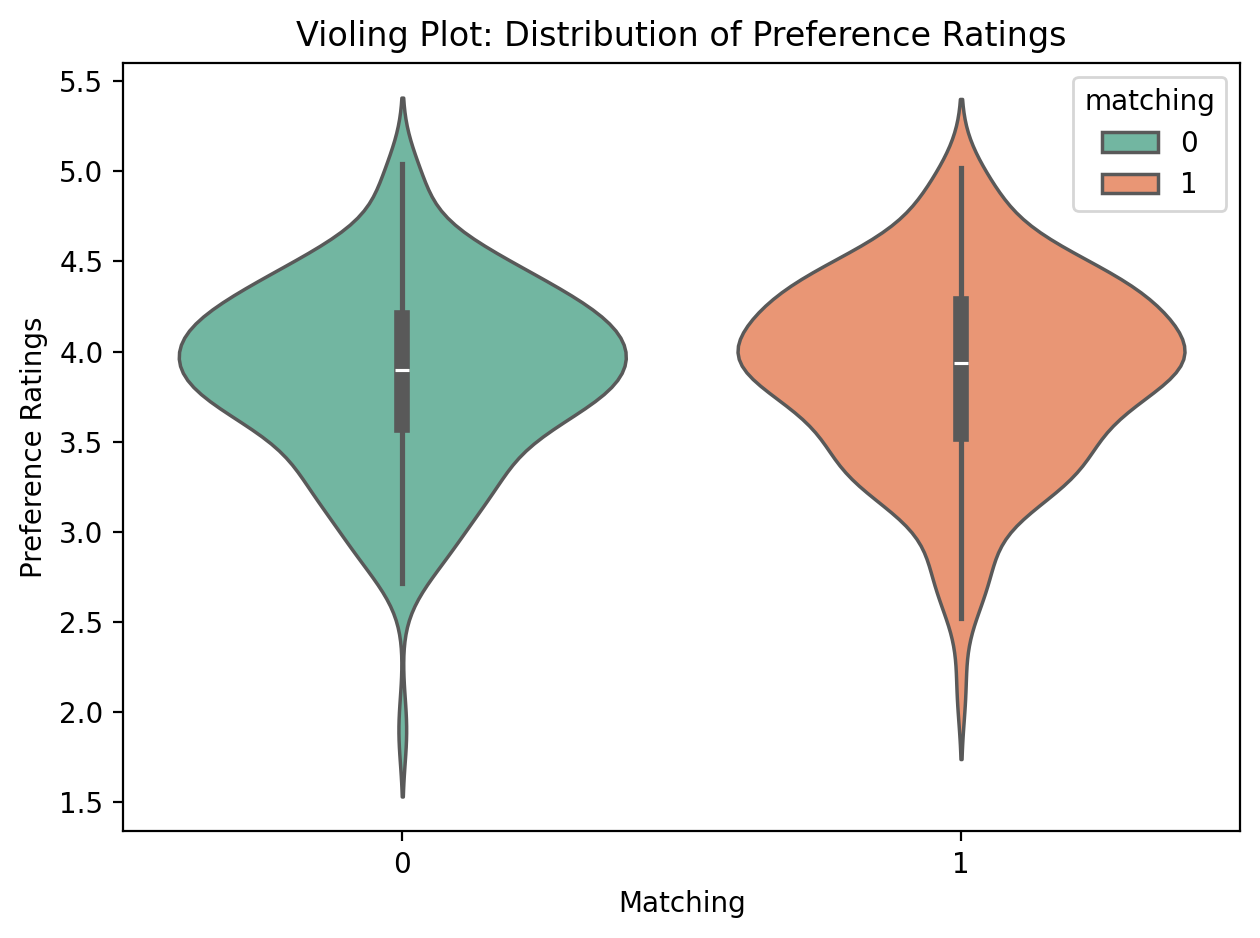

In [14]:
# Voilinplot of preference ratings for matching vs non-matching
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=None)

temp_df = perception_df.groupby(['ppnr', 'matching'])['preference'].mean().reset_index()

sns.violinplot(data=temp_df, x="matching", y="preference", orient='x', hue='matching', palette='Set2')
plt.title("Violing Plot: Distribution of Preference Ratings")

plt.xlabel('Matching')
plt.ylabel('Preference Ratings')

plt.tight_layout()

plt.savefig(f'{perception_results}/Distribution_of_preference-ratings.png')

plt.show()
plt.close(fig)

#### 2.2.2) Statistically Testing the difference between these 2 groups

In [15]:
## Levene-test 
from scipy import stats

res_ftest = stats.levene(preference_df['matching'], preference_df['non-matching'])

print(f"Levene: stat={res_ftest.statistic:.2f}, p-value={res_ftest.pvalue:.2f}")
print(f"H0: Samples come from Populations with equal Variance -> {'Reject' if res_ftest.pvalue < 0.05 else 'Fail to Reject'}")

Levene: stat=0.15, p-value=0.70
H0: Samples come from Populations with equal Variance -> Fail to Reject


In [16]:
## Paired two-tailed t-test
from scipy import stats

res_ttest = stats.ttest_rel(preference_df['matching'], preference_df['non-matching'], alternative='two-sided')

print(f"Paired T-test: stat={res_ttest.statistic:.2f}, p-value={res_ttest.pvalue:.2f}")
print(f"H0: Paired Population Means are Equal -> {'Reject' if res_ttest.pvalue < 0.05 else 'Fail to Reject'}")

Paired T-test: stat=1.12, p-value=0.26
H0: Paired Population Means are Equal -> Fail to Reject


### 2.3) Reaction-time for Matching v/s Non-Matching

In [17]:
## Mean reaction time for each participant

reaction_df = perception_df.groupby(['ppnr', 'matching'])['rt'].mean().unstack(level='matching').reset_index()

# reaction_df.rename(
#     columns= {
#         0: "non-matching",
#         1: "matching"
#     },
#     inplace=True,
# )

reaction_df.columns = ['ppnr', 'non-matching', 'matching']

reaction_df.head()

,ppnr,non-matching,matching
0,1,1.573176,1.538917
1,2,0.988190,1.041283
2,3,1.149694,1.076289
3,4,1.517900,1.559984
4,5,1.057371,1.134803


In [18]:
## Reaction time range for each participant

reaction_range_df = perception_df.groupby('ppnr')['rt'].agg(['min', 'max']).reset_index()
reaction_range_df.columns = ['ppnr', 'min', 'max']

reaction_range_df.head()

,ppnr,min,max
0,1,0.566298,4.070599
1,2,0.405251,3.016720
2,3,0.311169,3.186185
3,4,0.446313,3.993658
4,5,0.423373,3.081359


#### 2.3.1) Visualizing the Distribution of these 2 groups

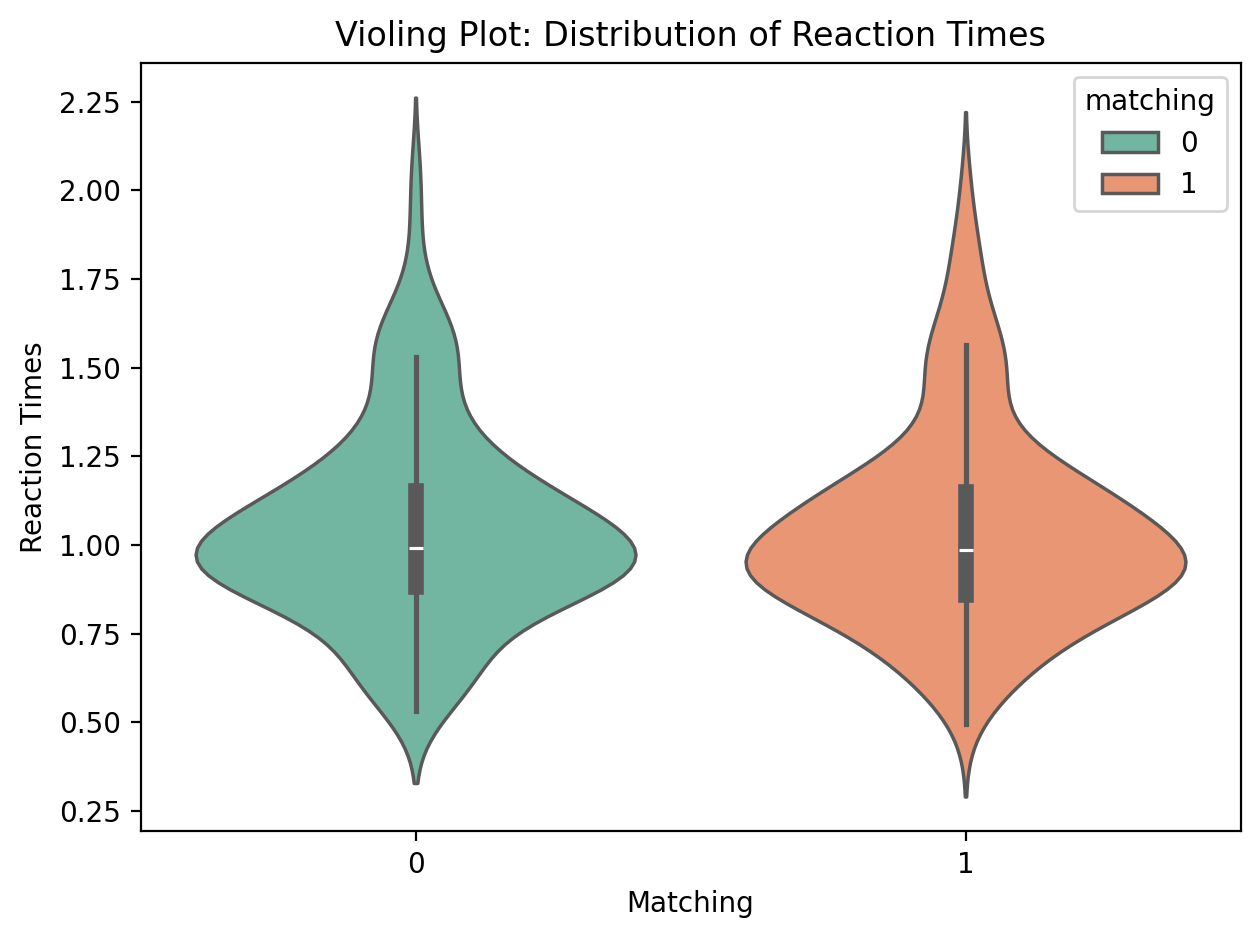

In [19]:
# Voilinplot of reaction times for matching vs non-matching
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=None)

temp_df = perception_df.groupby(['ppnr', 'matching'])['rt'].mean().reset_index()

sns.violinplot(data=temp_df, x="matching", y="rt", orient='x', hue='matching', palette='Set2')
plt.title("Violing Plot: Distribution of Reaction Times")

plt.xlabel('Matching')
plt.ylabel('Reaction Times')

plt.tight_layout()

plt.savefig(f'{perception_results}/Distribution_of_reaction-times.png')

plt.show()
plt.close(fig)

#### 2.3.2) Statistically Testing the difference between these 2 groups

In [20]:
## Levene-test 
from scipy import stats

res_ftest = stats.levene(reaction_df['matching'], reaction_df['non-matching'])

print(f"Levene: stat={res_ftest.statistic:.2f}, p-value={res_ftest.pvalue:.2f}")
print(f"H0: Samples come from Populations with equal Variance -> {'Reject' if res_ftest.pvalue < 0.05 else 'Fail to Reject'}")

Levene: stat=0.00, p-value=0.96
H0: Samples come from Populations with equal Variance -> Fail to Reject


In [21]:
## Paired two-tailed t-test
from scipy import stats

res_ttest = stats.ttest_rel(reaction_df['matching'], reaction_df['non-matching'], alternative='two-sided')

print(f"Paired T-test: stat={res_ttest.statistic:.2f}, p-value={res_ttest.pvalue:.2f} -> {'' if res_ttest.pvalue < 0.05 else ''}")
print(f"H0: Paired Population Means are Equal -> {'Reject' if res_ttest.pvalue < 0.05 else 'Fail to Reject'}")

Paired T-test: stat=-0.38, p-value=0.71 -> 
H0: Paired Population Means are Equal -> Fail to Reject


### 2.4) MODEL - 1

- `IV`: $\text{AQ\_total},\ \text{SRS\_total},\ \text{PCA\_factor}$
- `DV`: $\text{preference\_for\_match}$

In [22]:
## Correlation Table

corr_df = pd.concat([
    (preference_df['matching'] - preference_df['non-matching']),
    asd_df[['AQ_total', 'SRS_total', 'PCA_factor']]
], axis=1, ignore_index=False)

# corr_df = pd.merge(
#     (preference_df['matching'] - preference_df['non-matching']),
#     asd_df[['AQ_total', 'SRS_total', 'PCA_factor']], 
#     left_on='ppnr', right_on='subj',
#     how='inner'
# )

corr_df.rename(
    columns={
        0: 'preference_for_match'
    },
    inplace=True
)

display(corr_df.head())

,preference_for_match,AQ_total,SRS_total,PCA_factor
0,-0.162840,142.0,110.0,3.114122
1,-0.719184,83.0,32.0,-1.050444
2,0.700000,99.0,60.0,0.249674
3,0.006803,104.0,35.0,-0.185610
4,-0.183673,85.5,23.0,-1.180812


### 2.4.1) Correlation between Variables

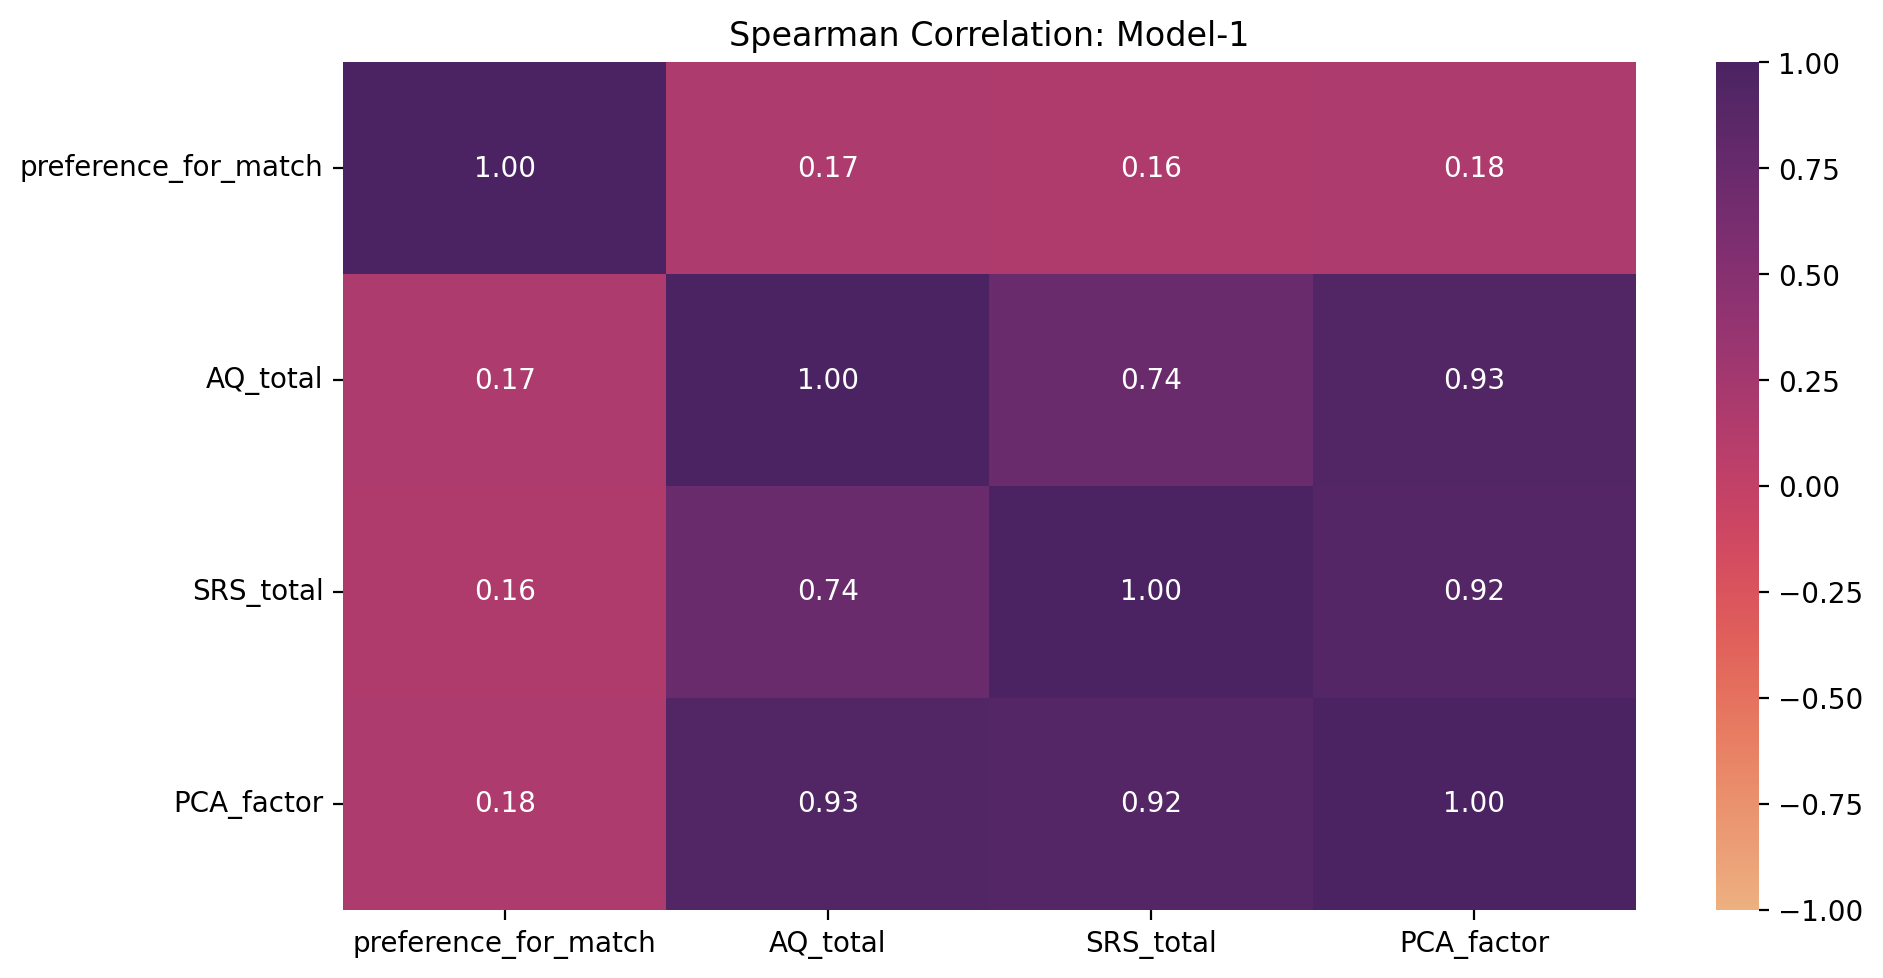

In [23]:
## Plotting Correlation

# Spearmann Correlation
corr_matrix = corr_df.corr(method='spearman', numeric_only=False)

fig = plt.figure(figsize=(10, 5))

sns.heatmap(corr_matrix, annot=True, vmax=1.0, vmin=-1.0, center=0.0, cmap='flare', fmt=".2f")
plt.title('Spearman Correlation: Model-1')

plt.tight_layout()

plt.savefig(f'{perception_results}/Correlation_model-1_spearman.png')

plt.show()
plt.close(fig)

### 2.4.2) Scatter Plot

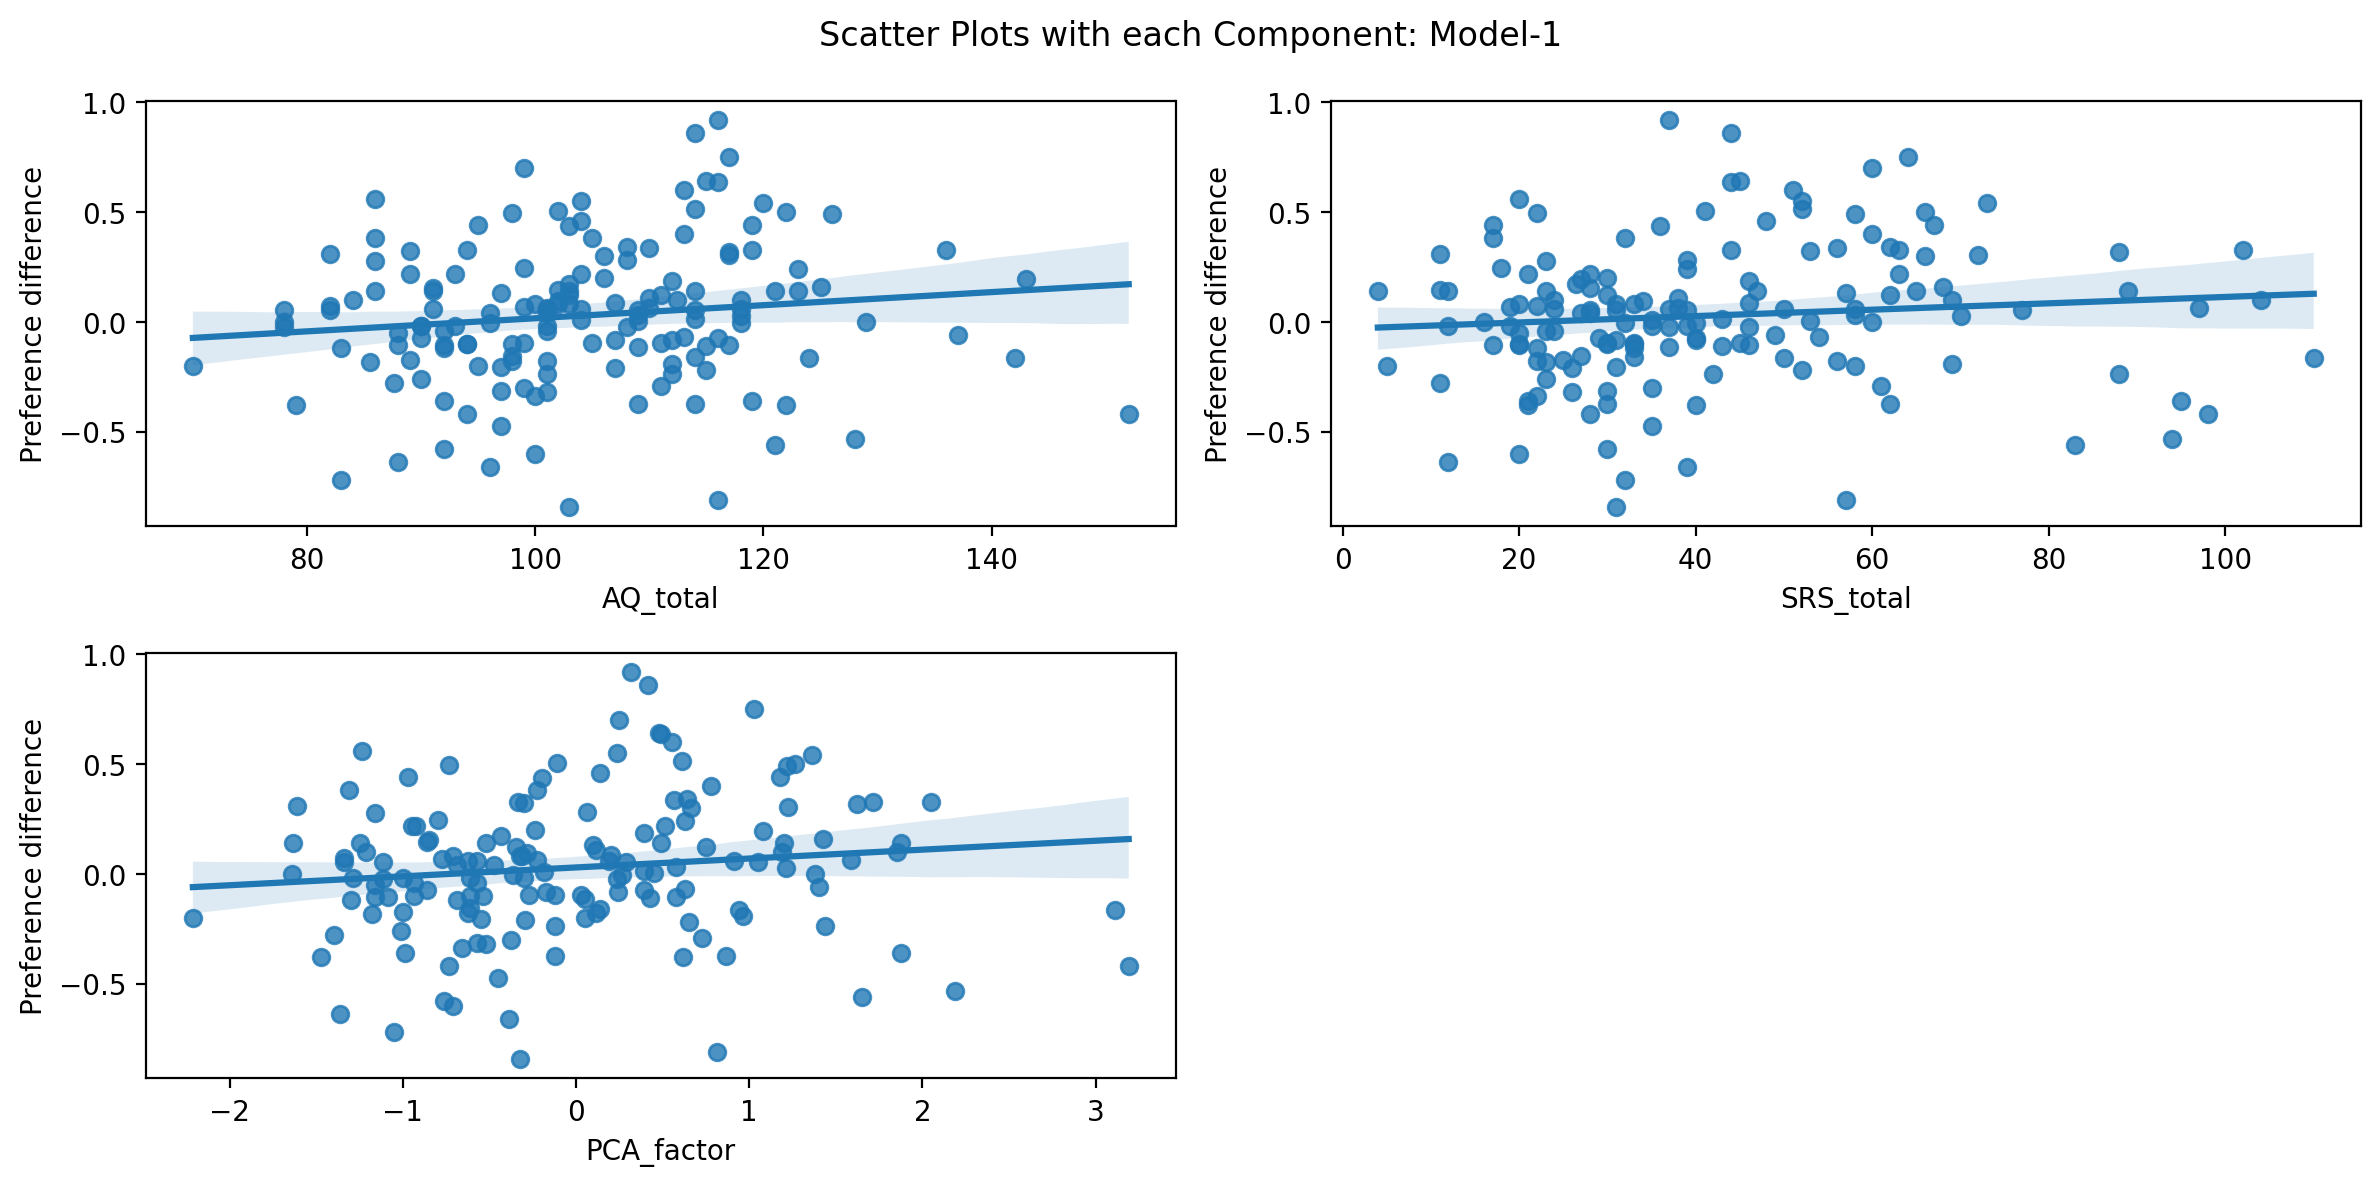

In [24]:
## Scatter Plots 
titles = ['AQ_total', 'SRS_total', 'PCA_factor']

n_rows, n_cols = (len(titles) + 1) // 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))  

for i in range(n_rows):
    for j in range(n_cols):
        if i == n_rows - 1 and j == n_cols - 1:
            axes[i, j].axis('off')
            continue
        
        # Scatter plot for 'PCA_factor'
        sns.regplot(ax=axes[i, j], x=titles[i * n_cols + j], y='preference_for_match', data=corr_df)
        axes[i, j].set_xlabel(titles[i * n_cols + j])
        axes[i, j].set_ylabel("Preference difference")

plt.suptitle('Scatter Plots with each Component: Model-1')
plt.tight_layout()

plt.savefig(f'{perception_results}/Scatter_model-1.png')

plt.show()
plt.close(fig)

### 2.4.3) OLS

In [25]:
X = corr_df[[col for col in corr_df.columns if col != 'preference_for_match']]
y = corr_df['preference_for_match']

In [26]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(data_df):
    vif_data = pd.DataFrame()
    
    vif_data["feature"] = data_df.columns
    vif_data["VIF"] = [variance_inflation_factor(data_df.values, i) for i in range(data_df.shape[1])]
    
    display(vif_data)

VIF(X)

,feature,VIF
0,AQ_total,16.187446
1,SRS_total,19.401449
2,PCA_factor,2.987317


In [27]:
## Fitting a Linear Model
X = sm.add_constant(X)

model =  sm.OLS(y, X).fit()

display(model.summary())
# print(f'R-squared: {model.rsquared:.3f}')
# print(f'F-statistic: {model.fvalue:.3f}')
# print(f'AIC: {model.aic:.3f}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     preference_for_match   R-squared:                       0.017
Model:                              OLS   Adj. R-squared:                  0.004
Method:                   Least Squares   F-statistic:                     1.337
Date:                  Fri, 12 Apr 2024   Prob (F-statistic):              0.266
Time:                          23:22:44   Log-Likelihood:                -41.918
No. Observations:                   156   AIC:                             89.84
Df Residuals:                       153   BIC:                             98.99
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.009     -1.177      0.241      -0.027       0.007
AQ_total       0.0008      0.001      0.757      0.450      -0.001       0.003
SRS_total     -0.0010      0.002     -0.427      0.670      -0.006       0.004
PCA_factor     0.0509      0.043      1.177      0.241      -0.035       0.136
==============================================================================
Omnibus:                        1.327   Durbin-Watson:                   2.417
Prob(Omnibus):                  0.515   Jarque-Bera (JB):                0.930
Skew:                          -0.072   Prob(JB):                        0.628
Kurtosis:                       3.349   Cond. No.                     3.45e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.71e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

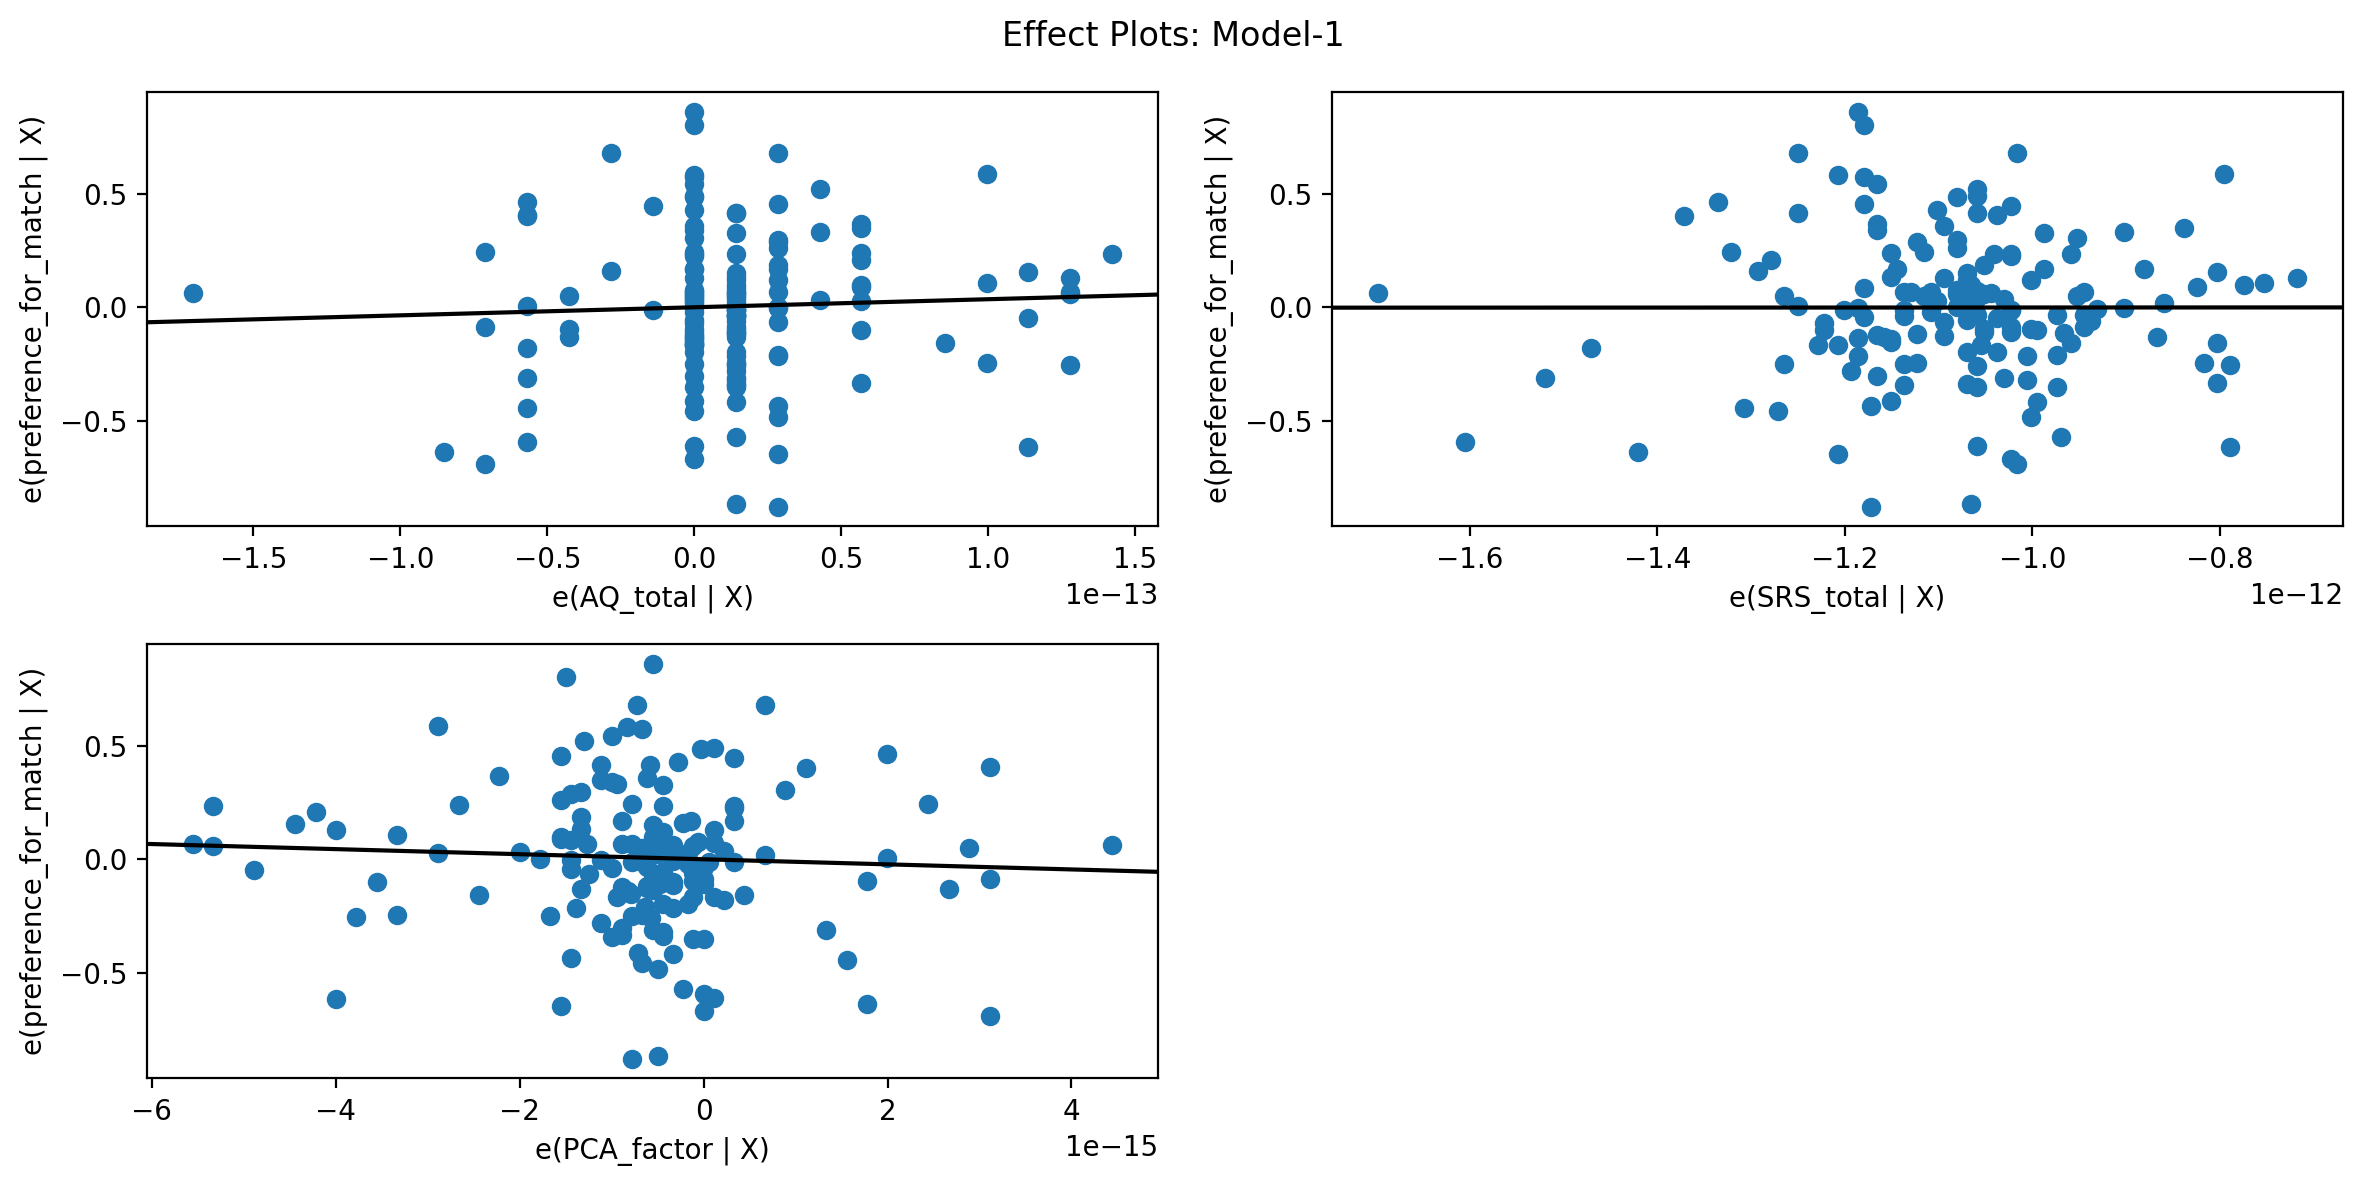

In [28]:
## Effect plots
from statsmodels.graphics.regressionplots import plot_partregress_grid

fig = plt.figure(figsize=(12, 6))

plot_partregress_grid(model, exog_idx=[1, 2, 3], fig=fig)

plt.suptitle(f'Effect Plots: Model-1')
plt.tight_layout()

plt.savefig(f'{perception_results}/Effect_model-1.png')

plt.show()
plt.close(fig)

### 2.5) MODEL - 2

- `IV`: $\text{AQ\_social},\ \text{AQ\_switch},\ \text{AQ\_detail},\ \text{AQ\_comm},\ \text{AQ\_imag},\ \text{SRS\_consc},\ \text{SRS\_comm},\ \text{SRS\_motiv},\ \text{SRS\_rigid}$
- `DV`: $\text{preference\_for\_match}$

In [29]:
## Correlation Table

sub_scales = ['AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']

corr_df = pd.concat([
    (preference_df['matching'] - preference_df['non-matching']),
    asd_df[sub_scales],
    # asd_df.iloc[:, 4:],
], axis=1, ignore_index=False)

# corr_df = pd.merge(
#     (preference_df['matching'] - preference_df['non-matching']),
#     asd_df[sub_scales],
#     # asd_df.iloc[:, 4:],
#     left_on='ppnr', right_on='subj',
#     how='inner'
# )

corr_df.rename(
    columns={
        0: 'preference_for_match'
    },
    inplace=True
)

display(corr_df.head())

,preference_for_match,AQ_social,AQ_switch,AQ_detail,AQ_comm,AQ_imag,SRS_consc,SRS_comm,SRS_motiv,SRS_rigid
0,-0.162840,29.0,34.0,27.0,22.0,30.0,24.0,37.0,26.0,23.0
1,-0.719184,17.0,17.0,19.0,18.0,12.0,12.0,8.0,7.0,5.0
2,0.700000,16.0,25.0,19.0,20.0,19.0,18.0,15.0,13.0,14.0
3,0.006803,16.0,24.0,21.0,22.0,21.0,11.0,14.0,7.0,3.0
4,-0.183673,16.0,19.0,19.0,15.5,16.0,9.0,4.0,4.0,6.0


### 2.5.1) Correlation between Variables

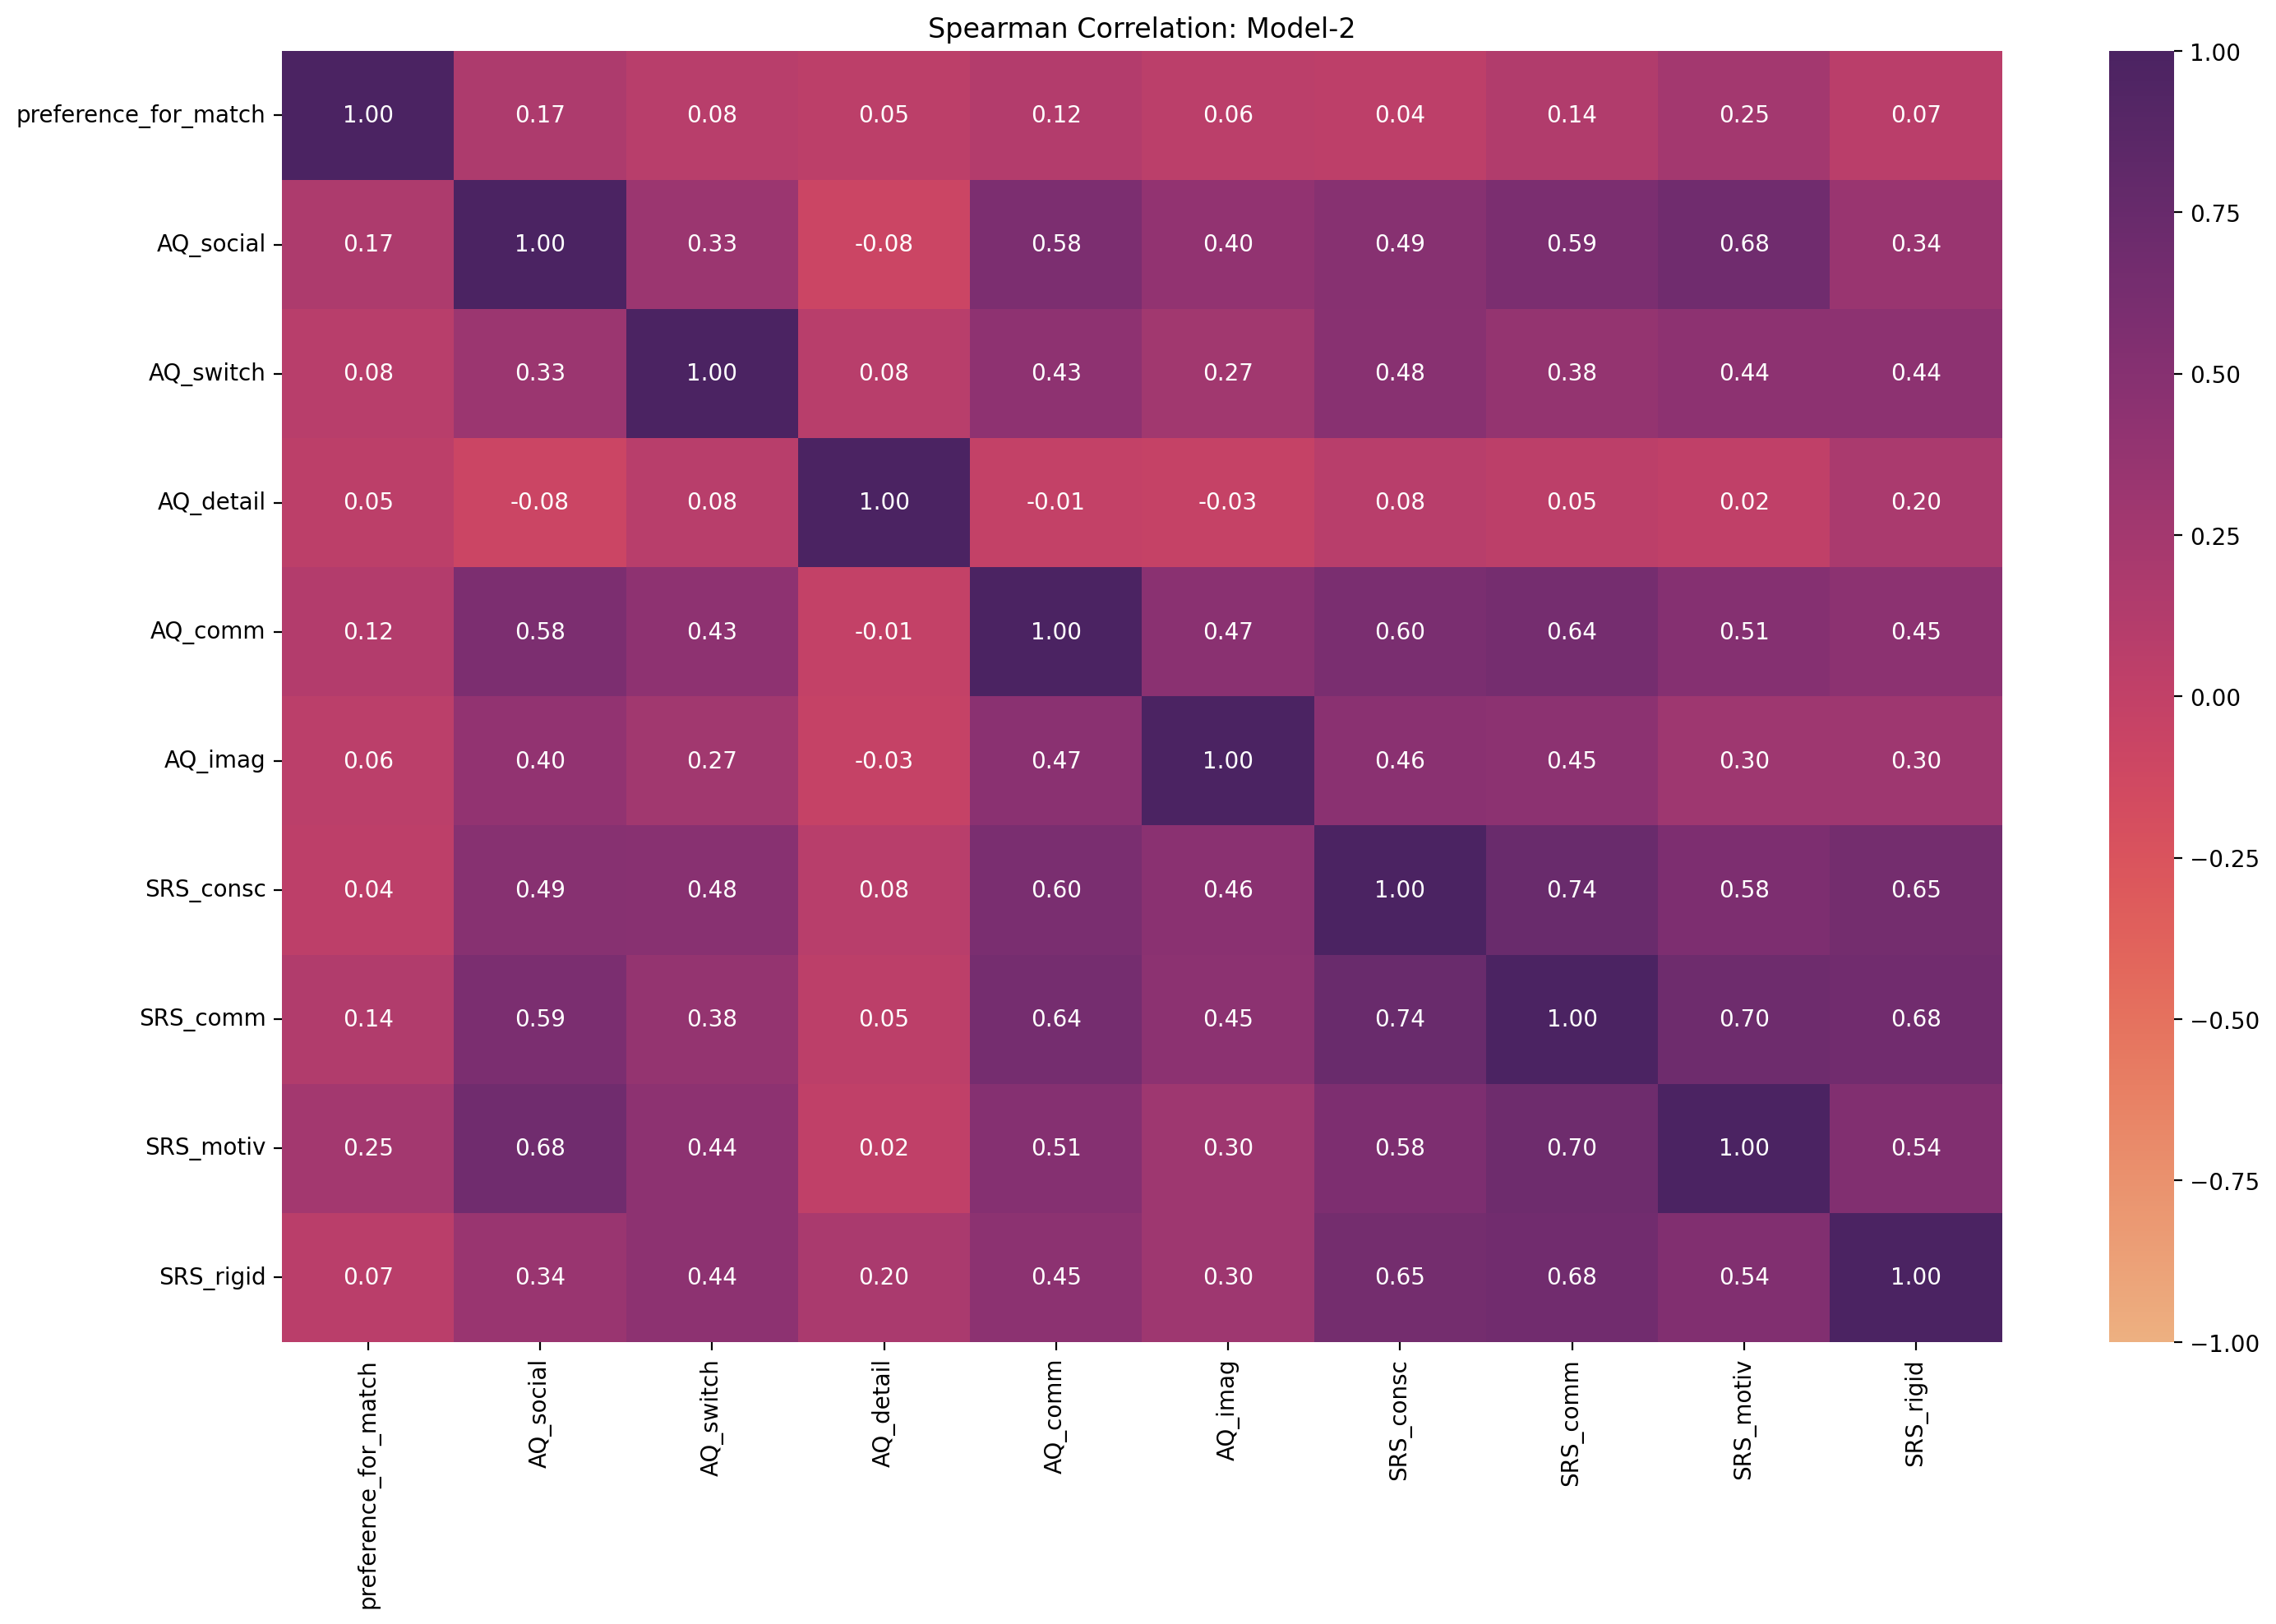

In [30]:
## Plotting Correlation

# Spearmann Correlation
corr_matrix = corr_df.corr(method='spearman', numeric_only=False)

fig = plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix, annot=True, vmax=1.0, vmin=-1.0, center=0.0, cmap='flare', fmt=".2f")
plt.title('Spearman Correlation: Model-2')

plt.tight_layout()

plt.savefig(f'{perception_results}/Correlation_model-2_spearman.png')

plt.show()
plt.close(fig)

### 2.5.2) Scatter Plot

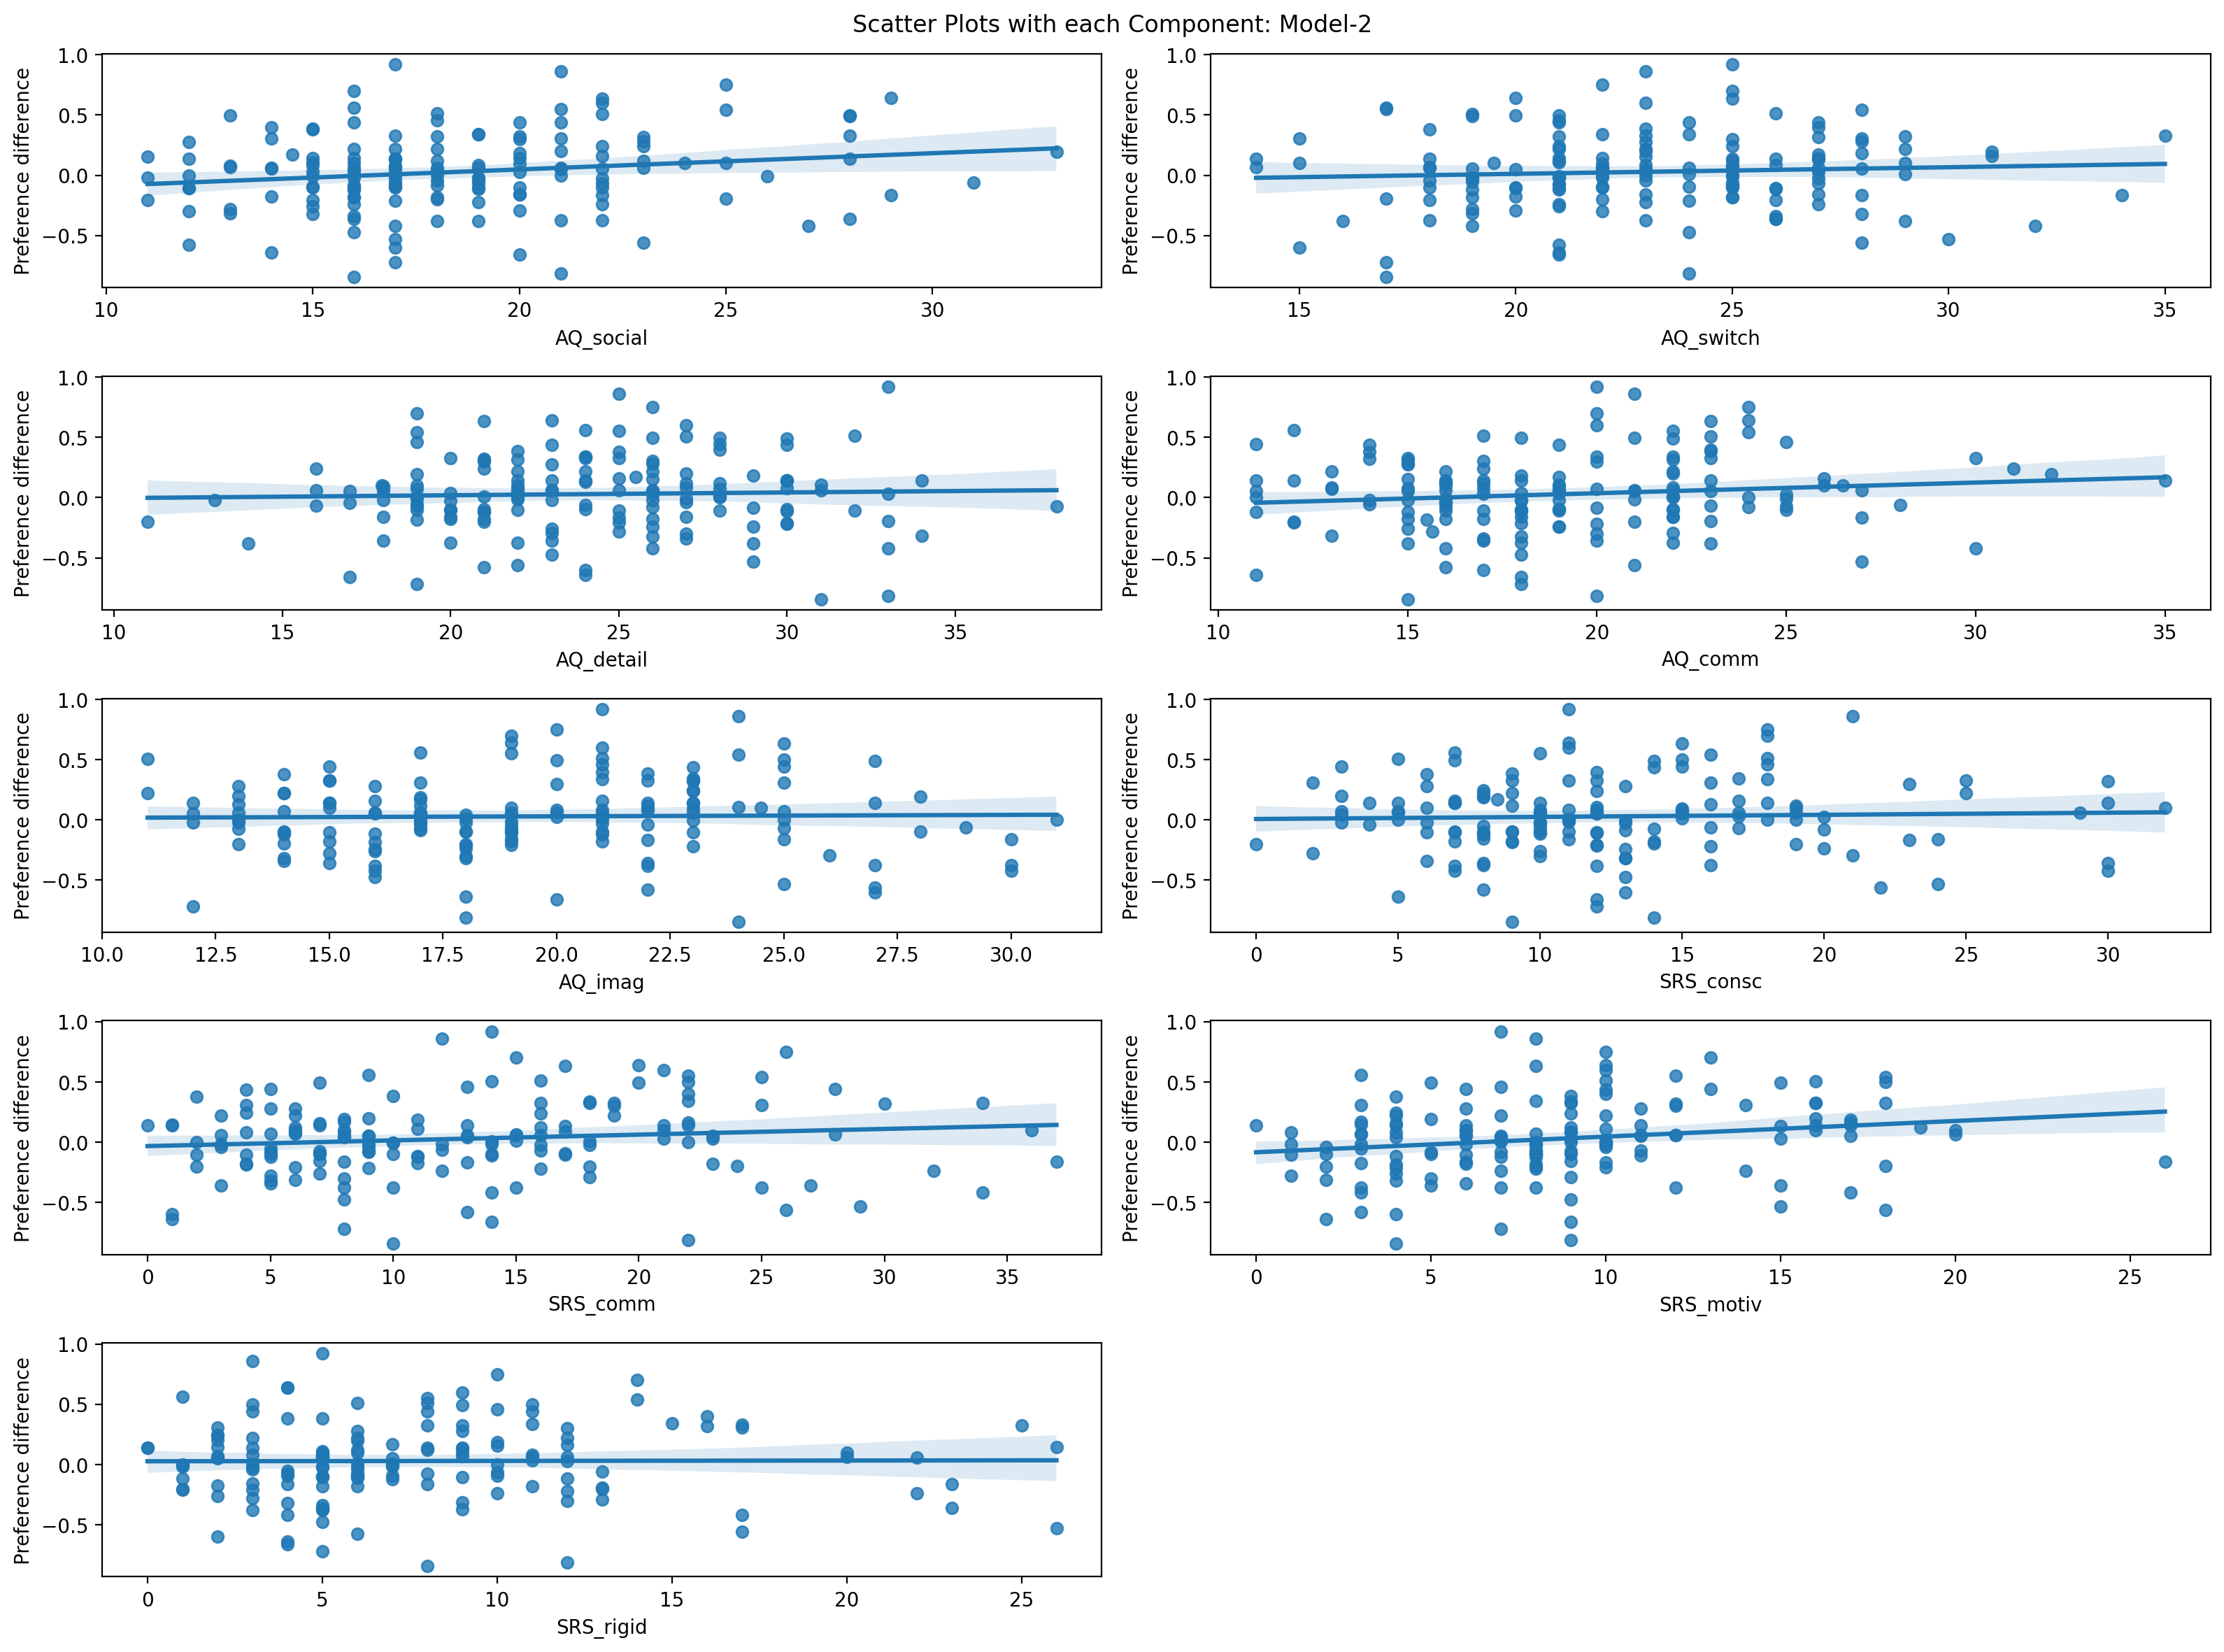

In [31]:
## Scatter Plots 
titles = sub_scales

n_rows, n_cols = (len(titles) + 1) // 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  

for i in range(n_rows):
    for j in range(n_cols):
        if i == n_rows - 1 and j == n_cols - 1:
            axes[i, j].axis('off')
            continue
        
        # Scatter plot for 'PCA_factor'
        sns.regplot(ax=axes[i, j], x=titles[i * n_cols + j], y='preference_for_match', data=corr_df)
        axes[i, j].set_xlabel(titles[i * n_cols + j])
        axes[i, j].set_ylabel("Preference difference")


plt.suptitle('Scatter Plots with each Component: Model-2')
plt.tight_layout()

plt.savefig(f'{perception_results}/Scatter_model-2.png')

plt.show()
plt.close(fig)

### 2.5.3) OLS

In [32]:
X = corr_df[[col for col in corr_df.columns if col != 'preference_for_match']]
y = corr_df['preference_for_match']

In [33]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(data_df):
    vif_data = pd.DataFrame()
    
    vif_data["feature"] = data_df.columns
    vif_data["VIF"] = [variance_inflation_factor(data_df.values, i) for i in range(data_df.shape[1])]
    
    display(vif_data)

VIF(X)

,feature,VIF
0,AQ_social,45.430009
1,AQ_switch,42.120450
2,AQ_detail,18.749191
3,AQ_comm,39.107150
4,AQ_imag,28.064184
5,SRS_consc,14.843426
6,SRS_comm,15.501543
7,SRS_motiv,12.388884
8,SRS_rigid,9.385424


In [34]:
## Fitting a Linear Model
X = sm.add_constant(X)

model =  sm.OLS(y, X).fit()

display(model.summary())
# print(f'R-squared: {model.rsquared:.3f}')
# print(f'F-statistic: {model.fvalue:.3f}')
# print(f'AIC: {model.aic:.3f}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     preference_for_match   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     1.379
Date:                  Fri, 12 Apr 2024   Prob (F-statistic):              0.202
Time:                          23:22:50   Log-Likelihood:                -36.904
No. Observations:                   156   AIC:                             93.81
Df Residuals:                       146   BIC:                             124.3
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2296      0.235     -0.976      0.331      -0.695       0.235
AQ_social      0.0039      0.009      0.412      0.681      -0.015       0.022
AQ_switch      0.0007      0.008      0.086      0.931      -0.015       0.017
AQ_detail      0.0038      0.006      0.696      0.488      -0.007       0.015
AQ_comm        0.0074      0.008      0.914      0.362      -0.009       0.023
AQ_imag       -0.0049      0.007     -0.711      0.478      -0.019       0.009
SRS_consc     -0.0052      0.007     -0.738      0.462      -0.019       0.009
SRS_comm       0.0057      0.007      0.866      0.388      -0.007       0.019
SRS_motiv      0.0142      0.009      1.559      0.121      -0.004       0.032
SRS_rigid     -0.0129      0.008     -1.566      0.120      -0.029       0.003
==============================================================================
Omnibus:                        1.362   Durbin-Watson:                   2.414
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                0.984
Skew:                          -0.025   Prob(JB):                        0.611
Kurtosis:                       3.386   Cond. No.                         486.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

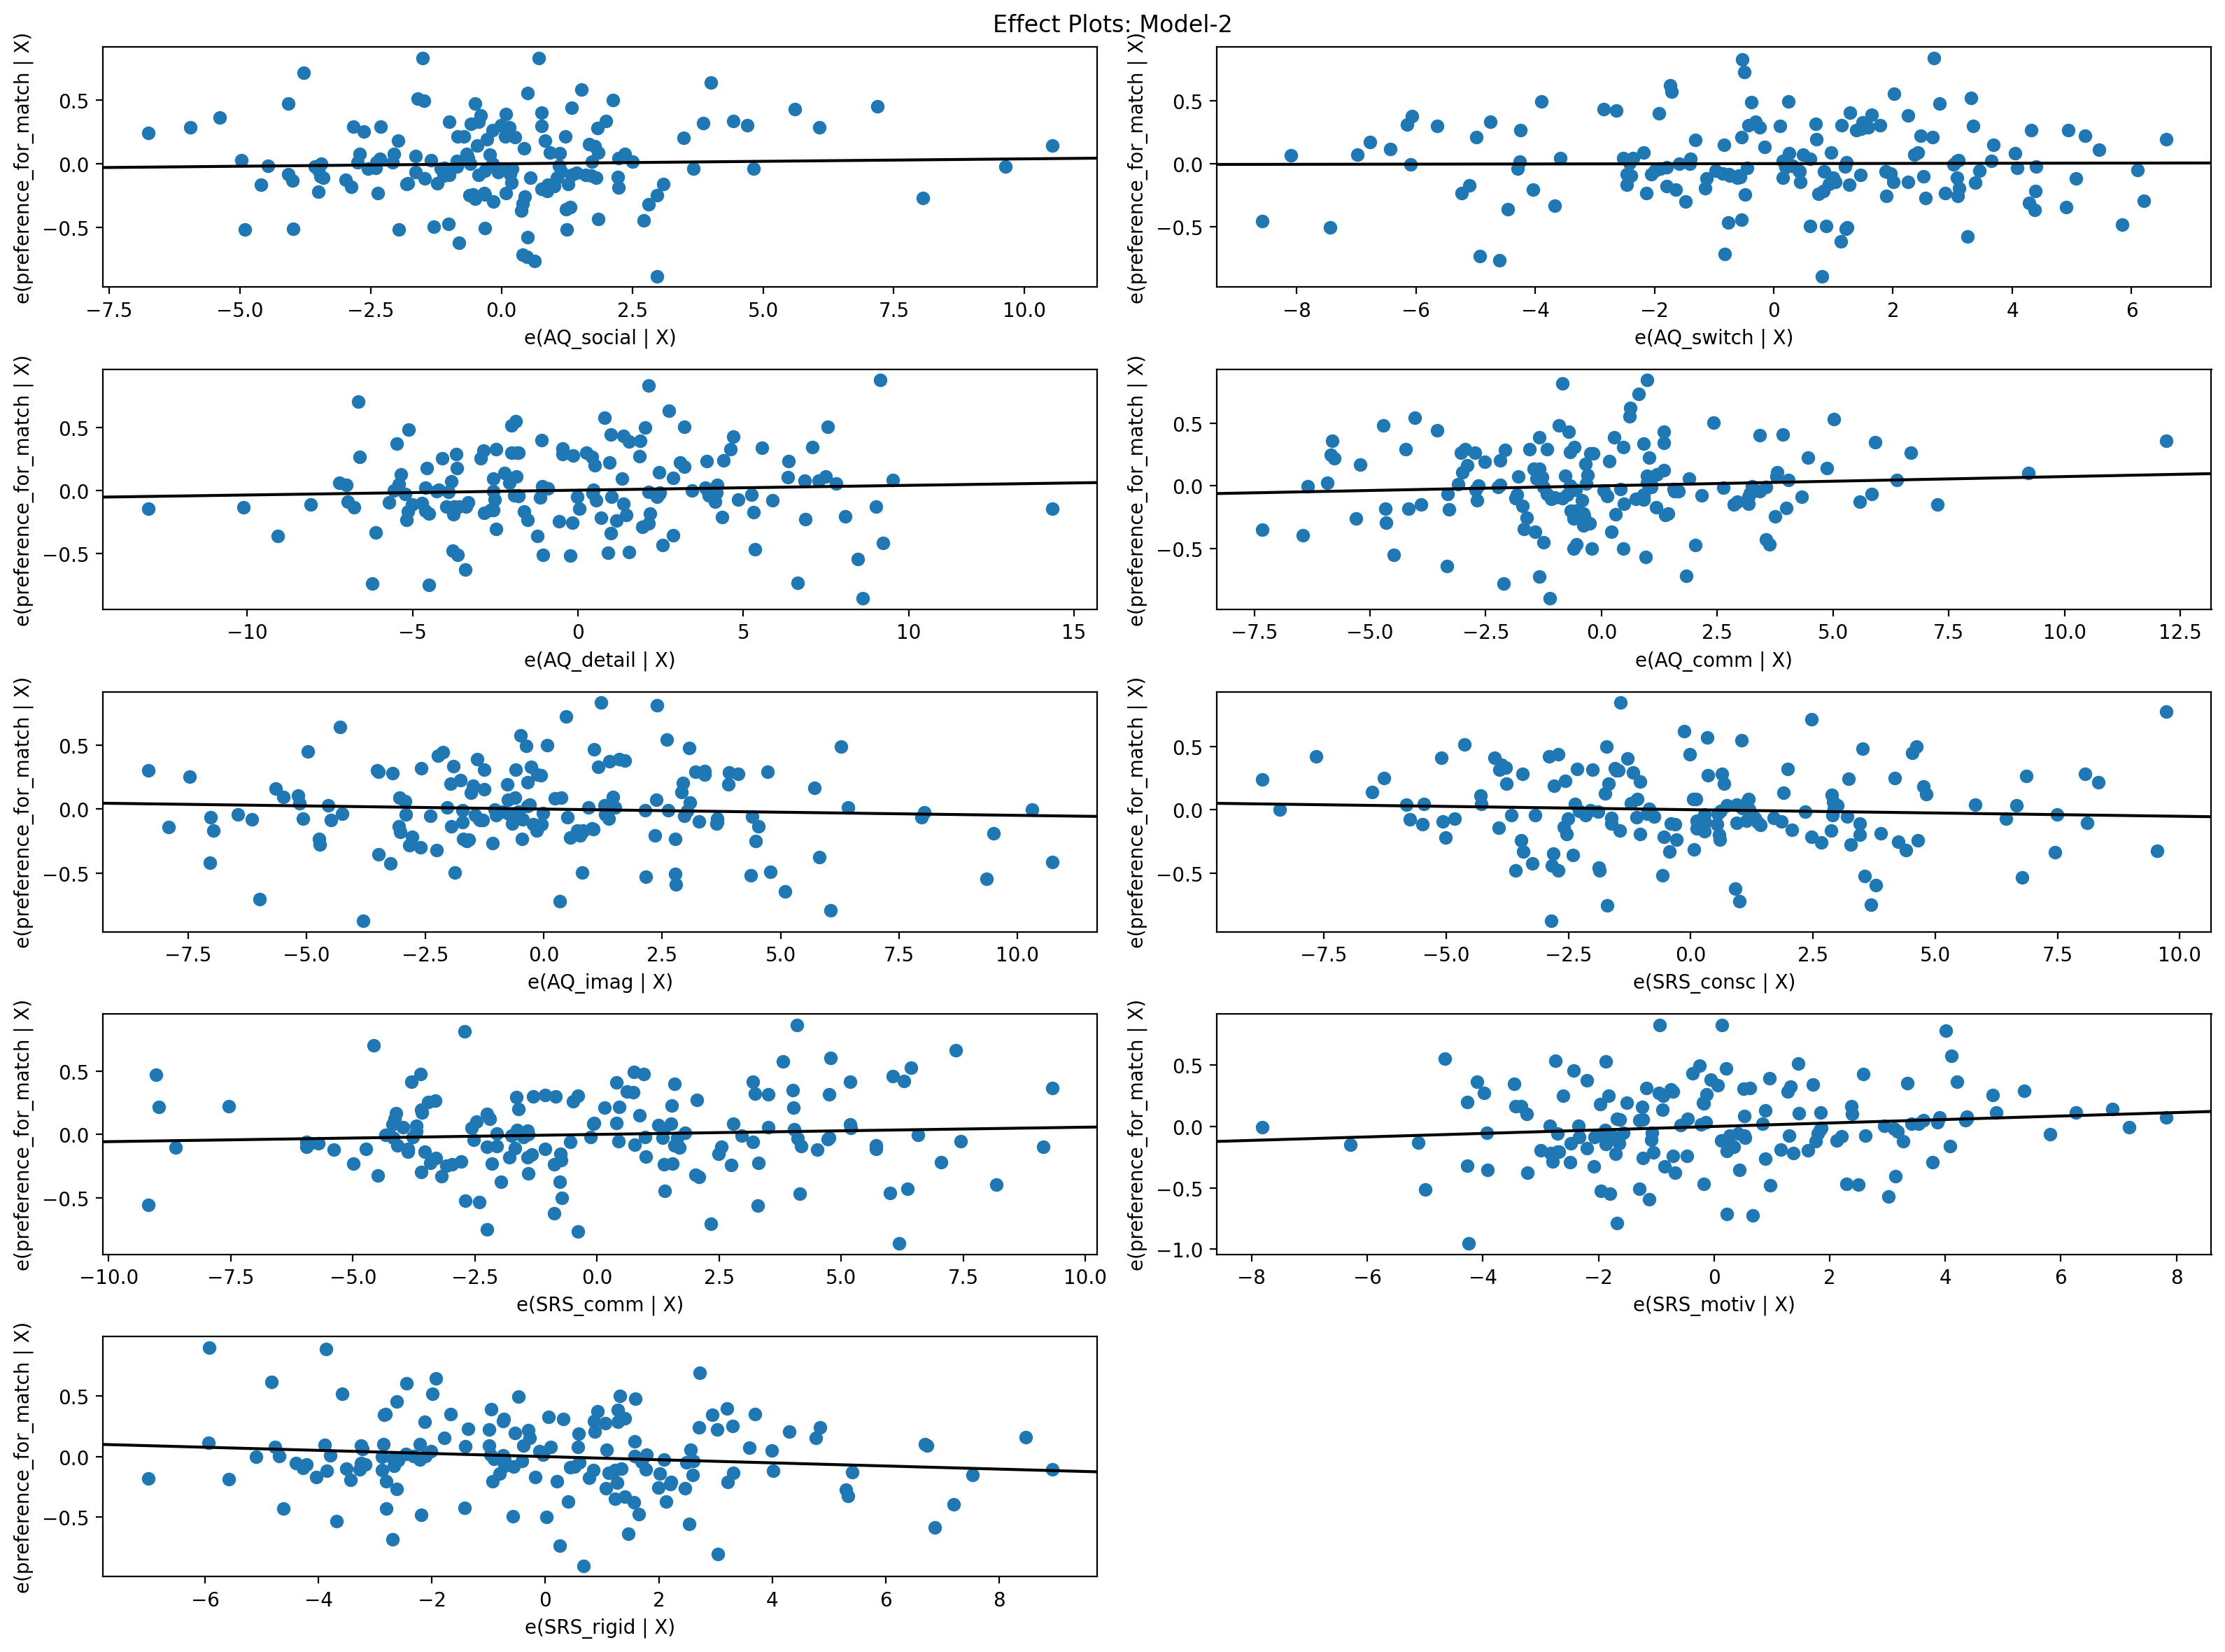

In [35]:
## Effect plots
from statsmodels.graphics.regressionplots import plot_partregress_grid

fig = plt.figure(figsize=(16, 12))

plot_partregress_grid(model, exog_idx=list(range(1, len(X.columns))), fig=fig)

plt.suptitle(f'Effect Plots: Model-2')
plt.tight_layout()

plt.savefig(f'{perception_results}/Effect_model-2.png')

plt.show()
plt.close(fig)